# Dynamic Factor Analysis on Stock Price Movements

This notebook explores stock price movements from the lens of dynamic factor analysis. As an unsupervised approach, the dynamic factor model directly estimates the values of the underlying factors from observed stock price data through the application of state-space methods and the Kalman filter. By employing this method, the model provides a means to filter the systematic and idiosyncratic components that contribute to stock price movements, shedding light on their distinct influences. 

Suppose $R_{it}$ is the return of stock $i$ at time $t$. The dynamic factor model assumes the following dynamics
\begin{align*}
    R_{it} &= \boldsymbol{\beta_i}^\top \boldsymbol{F_t} + \sigma_i Z_{it} \\
    \boldsymbol{F_t} &= \boldsymbol{\Lambda_1}\boldsymbol{F_{t-1}} + \boldsymbol{\Lambda_2}\boldsymbol{F_{t-2}} + \cdots + \boldsymbol{\Lambda_p}\boldsymbol{F_{t-p}} + \boldsymbol{\varepsilon_t} \\
    Z_{it} &= \psi_{i1} Z_{i(t-1)} + \psi_{i2} Z_{i(t-2)} + \cdots + \psi_{iq} Z_{i(t-q)} + \gamma_{it},
\end{align*}
where $\boldsymbol{F_t}$ is a vector of $n$ common factors at time $t$, $Z_{it}$ is a stock-specific factor for stock $i$ at time $t$, $\boldsymbol{\beta_i}$ is the loadings of stock $i$ for the common factors, $\sigma_i$ is the loading of stock $i$ for the stock-specific factor, $\boldsymbol{\Lambda_j}$'s are $n \times n$ VAR coefficient matrices, $\psi_{ij}$'s are AR coefficients, and $\boldsymbol{\varepsilon_t} \sim N\left(\boldsymbol{0}, \boldsymbol{I_n}\right)$, $\gamma_{it} \sim N(0,1)$ are Gaussian noise processes. Furthermore, $\gamma_{it}$ and $\gamma_{jt'}$ are independent for all $i \neq j$.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import dynamicfactoranalysis as dfa

This notebook considers the stocks in the Philippine Stock Exchange (PSE) from the period January 1, 2015 to December 31, 2020. To maintain the integrity of the data, stocks with more than 1% missing observations are dropped from the analysis. The composite index (PSEi) is used as comparision against the obtained common factor.

In [2]:
pse = pd.read_csv('data/PSE.csv', parse_dates=['dt'], index_col='dt')
pse = 100 * pse.pct_change(fill_method=None)
pse = pse.loc[dt.datetime(2015, 1, 1) : dt.datetime(2020, 12, 31)]
pse.index = pd.PeriodIndex(pse.index, freq='C')
pse = pse.dropna(axis=1, thresh=0.99*pse.shape[0])

index = pse[['PSEi']]
pse = pse.drop(columns=['PSEi'])

The optimizer `dynamicfactoranalysis.DynamicFactorModelOptimizer` is used to determine the optimal DFM orders following Bai & Ng (2002) and Bai & Ng (2008). The orders `k_factors` and `factor_order` are explored up to order 5 while `factor_lag` and `error_order` are set at 0 for simplicity.

In [3]:
optimizer = dfa.DynamicFactorModelOptimizer(endog=pse.reset_index(drop=True), k_factors_max=5, factor_lag_max=0, factor_order_max=5, error_order=0)
dfm = optimizer.fit(factor_ic=2, evolution_ic='bic', Dstat=2, delta=0.1, m=1, verbose=True)
res = dfm.fit(method='powell', disp=False)

DynamicFactorModelOptimizer results
k_factors: 1, factor_lag: 0, factor_order: 3


The common factor $F_t$ is then compared against the return of PSEi, the composite index of the Philippine Stock Exchange, as seen below. Generally, composite indices contain a diversified portfolio of stocks in a particular market. Thus, stock-related movements and risks are diversified away and only systematic movements and risks remain. Consequently, the PSEi is commonly used as a proxy for systematic movements in the market. The (Kalman smoothed) common factor $F_t$ and the PSEi are shown to be highly correlated, establishing the common factor as an appropriate indicator for systematic movements in the market.  

PSEi returns & common factor correlation: 0.92877


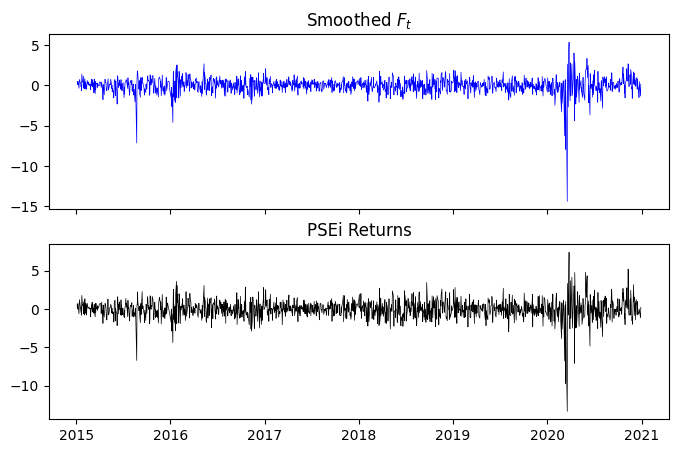

In [4]:
index['common_factor'] = res.factors.smoothed[0]
fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
axs[0].set_title(r'Smoothed $F_t$')
axs[0].plot(index.index.to_timestamp(), index['common_factor'], c='blue', linewidth=0.5)
axs[1].set_title('PSEi Returns')
axs[1].plot(index.index.to_timestamp(), index['PSEi'], c='black', linewidth=0.5)
fig.show()

print(f'PSEi returns & common factor correlation: {index["PSEi"].corr(index["common_factor"]):.5f}')

The loading $\beta_{i}$ is then compared against the CAPM beta, widely accepted as a measure of exposure to market risks. The figure below also shows a strong positive correlation between the two measures, further validating model's results.

CAPM beta & DFM beta correlation: 0.84193


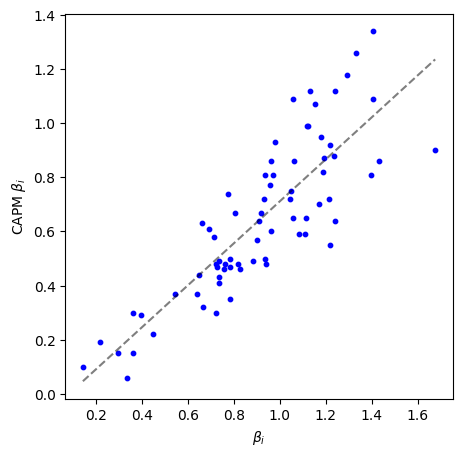

In [5]:
params = res.params.reset_index()
params.columns = ['parameter', 'value']
params[['parameter', 'stock']] = params['parameter'].str.rsplit('.', n=1, expand=True)
params = params.loc[(params['parameter'].str.contains('loading'))]
params = params.pivot(columns='parameter', index='stock', values='value')
beta = pd.read_csv('data/PSE_Barrons.csv')
beta = beta.rename(columns={'Stock Symbol': 'stock'})
beta = beta.join(params, on='stock', how='right').reset_index(drop=True)

fig = plt.figure(figsize=(5,5))
plt.scatter(beta[f'loading.f1'], beta['Beta'], c='blue', s=10)
m, b = np.polyfit(beta['loading.f1'], beta['Beta'], 1)
x = np.linspace(beta['loading.f1'].min(), beta['loading.f1'].max(), 1000)
plt.plot(x, m * x + b, '--', c='black', alpha=0.5)
plt.xlabel(r'$\beta_i$')
plt.ylabel(r'CAPM $\beta_i$')
fig.show()

print(f'CAPM beta & DFM beta correlation: {beta["Beta"].corr(beta["loading.f1"]):.5f}')